# 5.2 In-prediction Exploration
In the notebook we'll see a method of exploration which applys some noise to the embeddings of movies as predictions are made, affecting their predicted rating.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_recommenders as tfrs

Loading data and metadata, and converting to to Datasets.

In [2]:
train_df = pd.read_csv('../local_data/train_data.csv', header=0)
test_df = pd.read_csv('../local_data/test_data.csv', header=0)
with open('../local_data/metadata.json', 'r') as f:
    metadata = json.load(f)

In [3]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]
all_cities = metadata['cities']
all_states = metadata['states']
all_ages = [str(int(i)) for i in metadata['ages']]
all_occupations = [str(int(i)) for i in metadata['occupations']]
all_genres = metadata['genres']
title_emb_len = metadata['title_emb_size']
na_value = metadata['string_na']

In [4]:
def convert_to_dataset(df):
    movie_features = ['movie', 'title_emb', 'genres', 'movie_year', 'rating']
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d['genres'] = np.transpose(np.array([d[x] for x in all_genres]))
    d['title_emb'] = np.transpose(np.array([d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    for x in all_genres + [f'title_emb_{i}' for i in range(title_emb_len)]:
        d.pop(x)
    d = {k:(np.expand_dims(v, axis=1) if k in movie_features else v) for k,v in d.items()}
    return tf.data.Dataset.from_tensor_slices(d)

train_dataset = convert_to_dataset(train_df)
test_dataset = convert_to_dataset(test_df)

The `ExplorationGaussianNoise` is a take on the original Keras `GaussianNoise` layer. Thwe original is meant to be used as a regularization layer, and is therefore only active during training. We need the exact opposite - we'd like the layer to deactivate while training (so the model won't need to handle the noise), but be active while predictions are made. To do so, we only need to rewire the inputs of the `in_train_phase` method. For more details and demo of this layer, see the _partial solution_ section of this milestone.

In [5]:
class ExplorationGaussianNoise(tf.keras.layers.GaussianNoise):  # keras==2.6.0
    def __init__(self, stddev, seed=None, **kwargs):
        super(ExplorationGaussianNoise, self).__init__(stddev, **kwargs)

    def call(self, inputs, training=None):
        def noised():
            return inputs + tf.keras.backend.random_normal(
                shape=tf.shape(inputs),
                mean=0.,
                stddev=self.stddev,
                dtype=inputs.dtype)
        return tf.keras.backend.in_train_phase(inputs, noised, training=training)  # flipped inputs and noised

The model below matches the same one used in the previous milestone, except fotr the noise layer added on top of the `movie_emb` layer.

In [6]:
class RatingPredictionModel(tfrs.models.Model):
    def __init__(self, stddev):
        super().__init__()
        
        tower_last_layer_size = 50
        large_embedding_size = 25
        medium_embedding_size = 5
        small_embedding_size = 3
        
        # User tower
        
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, large_embedding_size, name='user_emb')(self.user_sl), axis=1)
        
        self.city_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='city_input')
        self.city_sl = tf.keras.layers.StringLookup(vocabulary=all_cities, mask_token=na_value, name='city_string_lookup')(self.city_input)
        self.city_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_cities)+2, medium_embedding_size, name='city_emb')(self.city_sl), axis=1)
        
        self.state_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='state_input')
        self.state_sl = tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup')(self.state_input)
        self.state_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_states)+2, small_embedding_size, name='state_emb')(self.state_sl), axis=1)
        
        self.age_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='age_input')
        self.age_sl = tf.keras.layers.StringLookup(vocabulary=all_ages, num_oov_indices=0, name='age_string_lookup')(self.age_input)
        self.age_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_ages), small_embedding_size, name='age_emb')(self.age_sl), axis=1)
        
        self.occupation_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='occupation_input')
        self.occupation_sl = tf.keras.layers.StringLookup(vocabulary=all_occupations, num_oov_indices=0, name='occupation_string_lookup')(self.occupation_input)
        self.occupation_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_occupations), small_embedding_size, name='occupation_emb')(self.occupation_sl), axis=1)
        
        self.gender_input = tf.keras.Input(shape=(1,), name='gender_input')
        self.hour_input = tf.keras.Input(shape=(1,), name='hour_input')
        self.day_input = tf.keras.Input(shape=(1,), name='day_input')
        self.month_input = tf.keras.Input(shape=(1,), name='month_input')
        
        self.user_merged = tf.keras.layers.concatenate([self.user_emb, self.city_emb, self.state_emb, self.age_emb, 
                                                        self.occupation_emb, self.gender_input, self.hour_input,
                                                        self.day_input, self.month_input], 
                                                       axis=-1, name='user_merged')
        self.user_dense = tf.keras.layers.Dense(100, activation='relu', name='user_dense')(self.user_merged)
        self.user_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='user_last_layer')(self.user_dense)
        
        # Movie tower
        
        self.movie_input = tf.keras.Input(shape=(None,1), dtype=tf.string, name='movie_input')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, large_embedding_size, name='movie_emb')(self.movie_sl), axis=2)
        self.movie_noise = ExplorationGaussianNoise(stddev=stddev)(self.movie_emb)
        
        self.title_input = tf.keras.Input(shape=(None,title_emb_len), name='title_input')
        self.title_dense = tf.keras.layers.Dense(title_emb_len, activation='softmax', name='title_softmax')(self.title_input)
        
        self.genres_input = tf.keras.Input(shape=(None,len(all_genres)), name='genres_input')
        self.year_input = tf.keras.Input(shape=(None,1), name='year_input')
        
        self.movie_merged = tf.keras.layers.concatenate([self.movie_noise, self.title_dense, self.genres_input, self.year_input] ,axis=-1, name='movie_merged')
        self.movie_dense = tf.keras.layers.Dense(100, activation='relu', name='movie_dense')(self.movie_merged)
        self.movie_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='movie_last_layer')(self.movie_dense)
        
        # Combining towers
        
        self.towers_multiplied = tf.keras.layers.Multiply(name='towers_multiplied')([tf.expand_dims(self.user_last_layer, axis=2), 
                                                                                     tf.transpose(self.movie_last_layer, perm=[0,2,1])])
        self.towers_dense1 = tf.keras.layers.Dense(40, activation='relu', name='towers_dense1')(tf.transpose(self.towers_multiplied, perm=[0,2,1]))
        self.towers_dense2 = tf.keras.layers.Dense(20, activation='relu', name='towers_dense2')(self.towers_dense1)
        self.output_node = tf.keras.layers.Dense(1, name='output_node')(self.towers_dense2)
        
        # Model definition
        
        self.model = tf.keras.Model(inputs={'user': self.user_input, 
                                            'city': self.city_input,
                                            'state': self.state_input,
                                            'age': self.age_input,
                                            'occupation': self.occupation_input,
                                            'gender': self.gender_input,
                                            'hour': self.hour_input,
                                            'day': self.day_input,
                                            'month': self.month_input,
                                            'movie': self.movie_input,
                                            'title': self.title_input,
                                            'genres': self.genres_input,
                                            'year': self.year_input
                                            }, 
                                    outputs=self.output_node)
        
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
    def call(self, features):
        return self.model({'user': tf.strings.as_string(features["user"]), 
                           'city': features["city"], 
                           'state': features["state"],
                           'age': tf.strings.as_string(features["age"]),
                           'occupation': tf.strings.as_string(features["occupation"]), 
                           'gender': features["gender"],
                           'hour': features["hour"],
                           'day': features["day"],
                           'month': features["month"],
                           'movie': tf.strings.as_string(features["movie"]),
                           'title': features["title_emb"],
                           'genres': features["genres"],
                           'year': features["movie_year"]
                           })
    
    def compute_loss(self, features_dict, training):
        labels = features_dict["rating"]
        predictions = self(features_dict)
        return self.task(labels=labels, predictions=predictions)

The new model requires us to specify the standard-deviation of the Gaussian noise which will be added to the movie embeddings:

In [7]:
model = RatingPredictionModel(stddev=0.8)
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, decay_steps=4000, decay_rate=0.95)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
cached_train = train_dataset.shuffle(15_000).batch(10_000).cache()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=5)
model.fit(cached_train, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
96/96 [==============================] - 18s 171ms/step - root_mean_squared_error: 27.1556 - loss: 722.4260 - regularization_loss: 0.0000e+00 - total_loss: 722.4260
Epoch 2/1000
96/96 [==============================] - 3s 33ms/step - root_mean_squared_error: 1.3293 - loss: 1.7701 - regularization_loss: 0.0000e+00 - total_loss: 1.7701 1s - root_mean_squared_error: 1.4159 - loss: 2.0049 - 
Epoch 3/1000
96/96 [==============================] - 3s 33ms/step - root_mean_squared_error: 1.2290 - loss: 1.5144 - regularization_loss: 0.0000e+00 - total_loss: 1.5144
Epoch 4/1000
96/96 [==============================] - 3s 31ms/step - root_mean_squared_error: 1.1903 - loss: 1.4217 - regularization_loss: 0.0000e+00 - total_loss: 1.4217
Epoch 5/1000
96/96 [==============================] - 3s 32ms/step - root_mean_squared_error: 1.1077 - loss: 1.2255 - regularization_loss: 0.0000e+00 - total_loss: 1.2255
Epoch 6/1000
96/96 [==============================] - 3s 33ms/step - root_mean_squa

Note that the RMSE of the evaluation phase below is calculated witht he noise layer active. Still, RMSE is lower than 1, and so we learn from this that the noise added is not too strong.

In [8]:
cached_test = test_dataset.batch(5000).cache()
model.evaluate(cached_test, return_dict=True)

11/11 [==============================] - 1s 46ms/step - root_mean_squared_error: 0.9830 - loss: 0.9895 - regularization_loss: 0.0000e+00 - total_loss: 0.9895


{'root_mean_squared_error': 0.9829643368721008,
 'loss': 1.106057047843933,
 'regularization_loss': 0,
 'total_loss': 1.106057047843933}

Next we select a user and 10 movies to use as test examples. In order to get movies with varying predictions, I decided to predict the ratings of 50 movies, and consider the top 5 and lowest 5 ranked movies as my test example.

Note that these prediction are being made without any noise applied. These are the original perdicted ratings, and it is done by calling the model directly with `training=True`, which deactivates the noise layer.

In [9]:
user_features = ['user','city','state','gender','age','occupation','hour','day','month']

def test_movies_dict(n=50):
    df = test_df.iloc[:n,:].drop(user_features+['rating'], axis=1)
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d['genres'] = np.transpose(np.array([d[x] for x in all_genres]))
    d['title_emb'] = np.transpose(np.array([d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    for x in all_genres + [f'title_emb_{i}' for i in range(title_emb_len)]:
        d.pop(x)
    d.update({k:np.expand_dims(np.vstack(v), axis=0) for k,v in d.items()})
    return d

def test_user_dict():
    test_user = dict(test_df[user_features].iloc[0])
    return {k:np.array([v]) for k,v in test_user.items()}

prediction_data = test_user_dict()
prediction_data.update(test_movies_dict())
predicted_ratings = model(prediction_data, training=True)  # turning off noise

movies_array = np.zeros((predicted_ratings.shape[1], 2))
for i in range(predicted_ratings.shape[1]):
    movies_array[i,0] = prediction_data['movie'][0,i,0]
    movies_array[i,1] = predicted_ratings[0,i,0]
    
movies_array = movies_array[np.argsort(-movies_array[:,1])]
movies_array = np.concatenate((movies_array[:5], movies_array[-5:]))
movies_array

array([[8.58000000e+02, 3.82164764e+00],
       [9.08000000e+02, 3.76364708e+00],
       [9.23000000e+02, 3.73762965e+00],
       [2.02800000e+03, 3.73701286e+00],
       [2.85800000e+03, 3.70663071e+00],
       [2.71000000e+03, 2.76729393e+00],
       [2.80500000e+03, 2.46923542e+00],
       [4.29000000e+02, 2.42861819e+00],
       [1.88200000e+03, 2.04177308e+00],
       [7.37000000e+02, 1.89899218e+00]])

We now predict the ratings of these 10 movies over and over again, 24 more times, with the noise layer activated. We indeed see a shift in the ranking order of the items, but on average, the original order is preserved.

<AxesSubplot:>

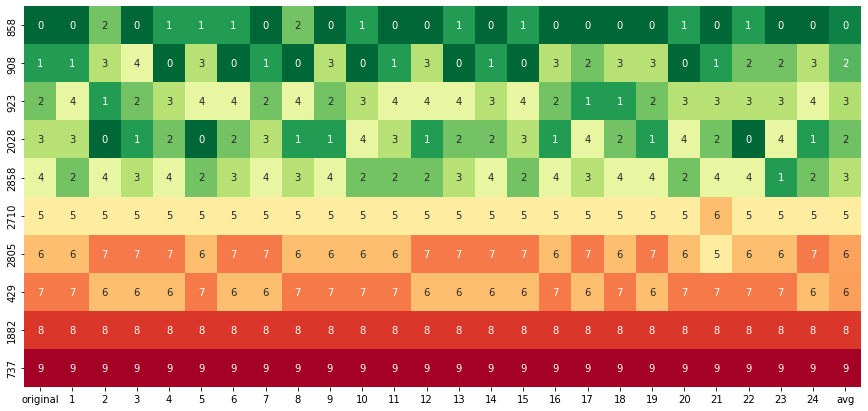

In [10]:
def noisy_prediction(movies_array):
    noisy = model.predict(prediction_data)
    a = np.stack([np.squeeze(prediction_data['movie']), np.squeeze(noisy)], axis=1)
    a = a[np.isin(a[:,0], movies_array[:,0])]
    return a[:,0][np.argsort(-a[:,1])]

num_tests = 25
results = np.zeros((movies_array.shape[0], num_tests))
results[:,0] = movies_array[:,0]
for i in range(1, num_tests):
    results[:,i] = noisy_prediction(movies_array)
    
heatmap_array = np.zeros_like(results)
for i,m in enumerate(movies_array[:,0]):
    idx = np.argwhere(results==m) 
    heatmap_array[i,:] = idx[np.argsort(idx[:,1])][:,0]
    
heatmap_df = pd.DataFrame(heatmap_array, index=[int(i) for i in movies_array[:,0]])
heatmap_df.rename(columns={0: 'original'}, inplace=True)
heatmap_df['avg'] = heatmap_df.apply(lambda row: row.drop('original').mean(), axis=1)
plt.figure(figsize=(15,7))
sns.heatmap(heatmap_df, annot=True, fmt='.0f', cbar=False, cmap='RdYlGn_r')

Saving model weights and plotting:

In [11]:
model.save_weights('weights_5_2/p52')

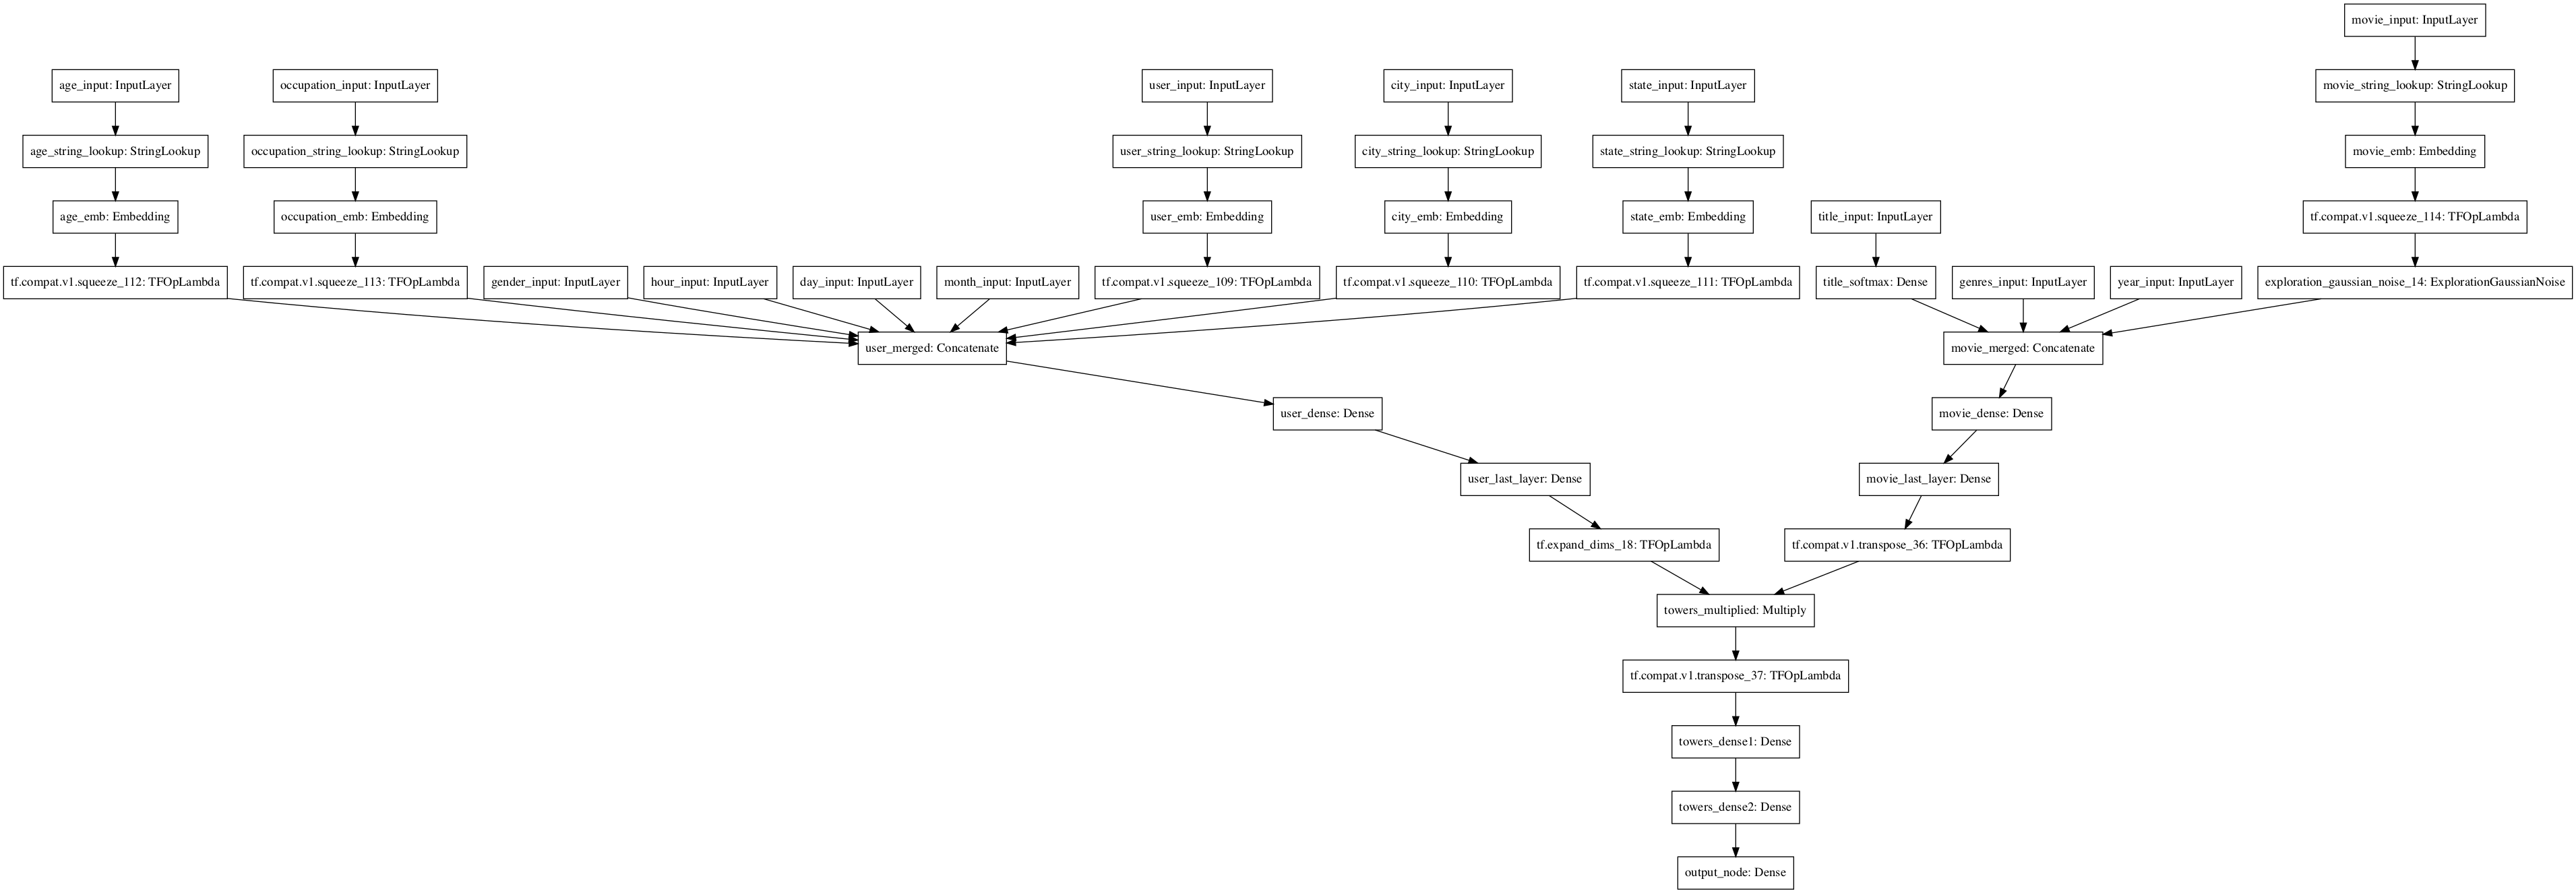

In [12]:
tf.keras.utils.plot_model(model.model, to_file="project_5_2.png")

In [13]:
model.model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_input (InputLayer)        [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
city_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
state_input (InputLayer)        [(None, 1)]          0                                            
___________________________________________________________________________________________